In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
from google.protobuf import text_format
import pprint
import json
import zipfile
import cv2
from pathlib import Path
from tensorflow.keras.models import load_model
from PIL import Image
import os

In [2]:
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && /content/

Cloning into 'models'...
remote: Enumerating objects: 90359, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 90359 (delta 79), reused 140 (delta 69), pack-reused 90207
Receiving objects: 100% (90359/90359), 608.42 MiB | 17.44 MiB/s, done.
Resolving deltas: 100% (65103/65103), done.
Updating files: 100% (3677/3677), done.
/bin/bash: line 1: /content/: Is a directory


In [3]:
!pip install --upgrade pip \
    && cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . \
    && python3 -m pip install .


Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1697356 sha256=d5ec92ae5c3080629e7f41b31deb1b1171a818ce1b7273f7ac86362c42f8b894
  Stored in directory: /tmp/pip-ephem-wheel-cache-kg0zijt0/wheels/53/dd/70/2de274d6c443c69d367bd6a5606f95e5a6df61aacf1435ec0d
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [4]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2
from object_detection.utils import label_map_util
from google.protobuf import text_format

In [7]:
zip_file_path = '/content/batch_1.zip'

extracted_dir_path = '/content/data/'

os.makedirs(extracted_dir_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

extracted_files = os.listdir(extracted_dir_path)
print("Files extracted:", extracted_files)


Files extracted: ['batch_1']


In [8]:

base_dir = Path('/content/data')

def draw_bounding_box(image, bbox, color=(255, 0, 0), thickness=2):
    # Unpack the bounding box
    x, y, w, h = bbox
    # Draw the bounding box
    cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), color, thickness)

# Function to display an image
def show_image(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Process each batch folder
for i in range(1, 16):  # Loop through all the batch folders
    batch_folder = base_dir / f'batch_{i}'

    #define the path for the annotations file within the batch folder
    annotations_path = batch_folder / 'annotations.json'

    # Check if the annotations file exists
    if not annotations_path.exists():
        print(f'Annotations file does not exist: {annotations_path}')
        continue

    # Load the annotations from the JSON file
    with open(annotations_path) as f:
        annotations = json.load(f)

    # Process each image and its annotations
    for image_info in annotations['images']:
        # Construct the full path to the image file
        image_path = batch_folder / image_info['file_name']

        # Check if the image file exists
        if not image_path.exists():
            print(f'Image file not found: {image_path}')
            continue

        # Load the image
        image = cv2.imread(str(image_path))

        # Check if the image was successfully loaded
        if image is None:
            print(f'Failed to load image: {image_path}')
            continue

        # Find the annotations for the current image
        image_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == image_info['id']]

        # Draw all bounding boxes on the image
        for ann in image_annotations:
            bbox = ann['bbox']
            draw_bounding_box(image, bbox)

        # Display the image with bounding boxes
        show_image(image)

        # Break after showing the first image for manual inspection
      #
        break

    # Break after processing the first batch for manual inspection
    break

In [9]:
root_dir = '/content'
json_annot_file = os.path.join(root_dir, 'annotations.json')
total_classes = 60

with open(json_annot_file, 'r') as file:
    annotations = json.load(file)

category_data = annotations['categories']

print('Commencing construction of the label mapping')

new_label_map = string_int_label_map_pb2.StringIntLabelMap()
for count, category in enumerate(category_data):
    map_entry = new_label_map.item.add()
    map_entry.id = int(category['id']) + 1
    map_entry.name = category['name']

label_map_file = './new_label_map.pbtxt'
with open(label_map_file, 'w') as output_file:
    output_file.write(text_format.MessageToString(new_label_map))

print('New label map has been saved to new_label_map.pbtxt')


transformed_label_map = label_map_util.load_labelmap(label_map_file)
processed_category_list = label_map_util.convert_label_map_to_categories(transformed_label_map, max_num_classes=total_classes, use_display_name=True)
mapped_categories = label_map_util.create_category_index(processed_category_list)

Commencing construction of the label mapping
New label map has been saved to new_label_map.pbtxt


In [10]:
with open(label_map_file, 'r') as read_file:
    pprint.pprint(read_file.readlines())

['item {\n',
 '  name: "Aluminium foil"\n',
 '  id: 1\n',
 '}\n',
 'item {\n',
 '  name: "Battery"\n',
 '  id: 2\n',
 '}\n',
 'item {\n',
 '  name: "Aluminium blister pack"\n',
 '  id: 3\n',
 '}\n',
 'item {\n',
 '  name: "Carded blister pack"\n',
 '  id: 4\n',
 '}\n',
 'item {\n',
 '  name: "Other plastic bottle"\n',
 '  id: 5\n',
 '}\n',
 'item {\n',
 '  name: "Clear plastic bottle"\n',
 '  id: 6\n',
 '}\n',
 'item {\n',
 '  name: "Glass bottle"\n',
 '  id: 7\n',
 '}\n',
 'item {\n',
 '  name: "Plastic bottle cap"\n',
 '  id: 8\n',
 '}\n',
 'item {\n',
 '  name: "Metal bottle cap"\n',
 '  id: 9\n',
 '}\n',
 'item {\n',
 '  name: "Broken glass"\n',
 '  id: 10\n',
 '}\n',
 'item {\n',
 '  name: "Food Can"\n',
 '  id: 11\n',
 '}\n',
 'item {\n',
 '  name: "Aerosol"\n',
 '  id: 12\n',
 '}\n',
 'item {\n',
 '  name: "Drink can"\n',
 '  id: 13\n',
 '}\n',
 'item {\n',
 '  name: "Toilet tube"\n',
 '  id: 14\n',
 '}\n',
 'item {\n',
 '  name: "Other carton"\n',
 '  id: 15\n',
 '}\n',
 'item 

In [11]:
# Function to rebuild a frozen TensorFlow graph from a .pb file
def rebuild_frozen_graph(pb_file_path):
    # Check if the .pb file exists
    if not os.path.exists(pb_file_path):
        print(f"Error: File '{pb_file_path}' does not exist.")
        return None

    print("Rebuilding TensorFlow graph from frozen model")
    graph = tf.Graph()
    with graph.as_default():
        graph_definition = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_file_path, mode='rb') as file:
            graph_content = file.read()
            graph_definition.ParseFromString(graph_content)
            tf.import_graph_def(graph_definition, name='')
    print("Graph reconstruction successful.")
    return graph


In [12]:
# Convert an image to a numpy array
def image_to_np_array(image):
    img_width, img_height = image.size
    return np.array(image.getdata()).reshape((img_height, img_width, 3)).astype(np.uint8)

# Convert an image to a tensor
def image_to_tensor(image):
    return np.expand_dims(image_to_np_array(image), axis=0)

%matplotlib inline

# Function to perform object detection
def run_detection(graph, image_file_path):
    with graph.as_default():
        session_opts = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01))
        with tf.compat.v1.Session(graph=graph, config=session_opts) as sess:
            tensors = {name: graph.get_tensor_by_name(f'{name}:0') for name in ['image_tensor', 'detection_boxes', 'detection_scores', 'detection_classes', 'num_detections']}

            # Process the image
            image = Image.open(image_file_path)
            tensor_input = image_to_tensor(image)

            # Detection
            output_tensors = sess.run(
                [tensors['detection_boxes'], tensors['detection_scores'], tensors['detection_classes'], tensors['num_detections']],
                feed_dict={tensors['image_tensor']: tensor_input}
            )

            # Display predictions
            print("Detected objects:")
            for i in range(int(output_tensors[3][0])):
                class_id = int(output_tensors[2][0][i])
                class_name = mapped_categories[class_id]['name']
                confidence = np.squeeze(output_tensors[1])[i]
                if confidence >= 0.5:
                    print(f"{class_name}: {confidence:.2f}")

            # Visualization on the image
            processed_image = image_to_np_array(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                processed_image,
                np.squeeze(output_tensors[0]),
                np.squeeze(output_tensors[2]).astype(np.int32),
                np.squeeze(output_tensors[1]),
                mapped_categories,
                use_normalized_coordinates=True,
                line_thickness=15
            )

            # Show the image
            plt.figure(figsize=(12, 8))
            plt.imshow(processed_image)
            plt.show()


In [13]:

# Load the frozen graph
graph_def = tf.compat.v1.GraphDef()
with tf.io.gfile.GFile('/content/object_detection.pb', 'rb') as f:
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')

for op in graph.get_operations():
    print(op.name)


Const
image_tensor
ToFloat
Preprocessor/map/Shape
Preprocessor/map/strided_slice/stack
Preprocessor/map/strided_slice/stack_1
Preprocessor/map/strided_slice/stack_2
Preprocessor/map/strided_slice
Preprocessor/map/TensorArray
Preprocessor/map/TensorArrayUnstack/Shape
Preprocessor/map/TensorArrayUnstack/strided_slice/stack
Preprocessor/map/TensorArrayUnstack/strided_slice/stack_1
Preprocessor/map/TensorArrayUnstack/strided_slice/stack_2
Preprocessor/map/TensorArrayUnstack/strided_slice
Preprocessor/map/TensorArrayUnstack/range/start
Preprocessor/map/TensorArrayUnstack/range/delta
Preprocessor/map/TensorArrayUnstack/range
Preprocessor/map/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3
Preprocessor/map/Const
Preprocessor/map/TensorArray_1
Preprocessor/map/TensorArray_2
Preprocessor/map/while/iteration_counter
Preprocessor/map/while/Enter
Preprocessor/map/while/Enter_1
Preprocessor/map/while/Enter_2
Preprocessor/map/while/Enter_3
Preprocessor/map/while/Merge
Preprocessor/map/whi

In [14]:
detection_graph = rebuild_frozen_graph("/content/object_detection.pb")

Rebuilding TensorFlow graph from frozen model
Graph reconstruction successful.


Detected objects:
Clear plastic bottle: 1.00
Plastic bottle cap: 0.99


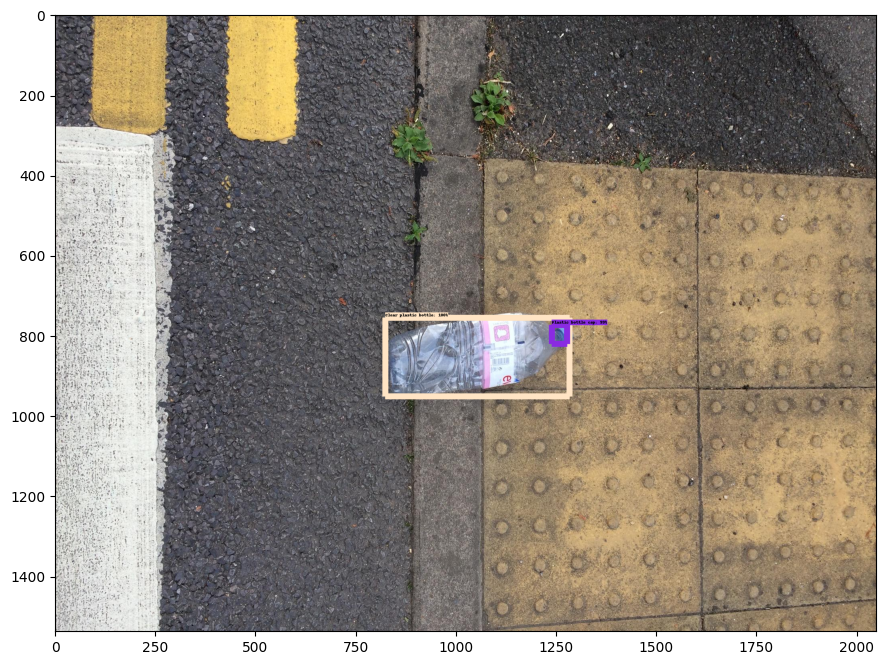

Detected objects:
Clear plastic bottle: 1.00
Plastic bottle cap: 0.99


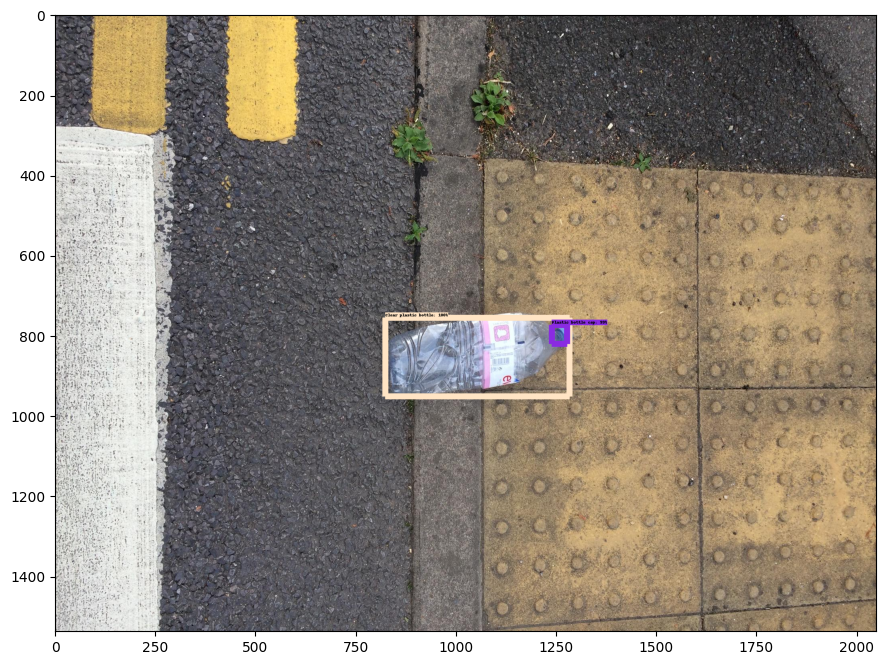

In [28]:
run_detection(detection_graph, '/content/data/batch_1/000001.jpg')

In [16]:
classification_model = load_model('/content/model3.h5')


In [17]:
classification_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                 

In [18]:
def detect_objects(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph, config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            image_np_expanded = image2tensor(image)

            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded}
            )

            width, height = image.size

            detected_objects = []
            for i in range(int(num[0])):
                class_id = int(classes[0][i])
                class_name = mapped_categories[class_id]['name']
                score = np.squeeze(scores)[i]

                if score >= 0.5:  # Threshold for confidence
                    box = boxes[0][i]
                    ymin, xmin, ymax, xmax = box
                    (left, right, top, bottom) = (xmin * width, xmax * width,
                                                  ymin * height, ymax * height)

                    detected_objects.append({
                        "class_name": class_name,
                        "score": score,
                        "box": [left, top, right, bottom]
                    })

            return detected_objects


In [19]:
# visualize detection
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

In [20]:
detect_objects(detection_graph, '/content/data/batch_1/000000.jpg')

[{'class_name': 'Clear plastic bottle',
  'score': 0.9768785,
  'box': [699.3882927298546,
   1220.8558398485184,
   860.4193319678307,
   1425.4803636074066]}]

In [21]:
def classify_waste(image):
    """
    Classify the type of waste using the loaded model.

    Args:
    image (PIL.Image): The image of the waste item.

    Returns:
    str: The predicted waste type.
    """
    image = image.resize((256, 256))  #model expects 256x256 input
    image_array = np.array(image) / 255.0  #Normalizing since the model was trained with normalized images
    image_array = np.expand_dims(image_array, axis=0)

    prediction = classification_model.predict(image_array)
    predicted_class = np.argmax(prediction, axis=1)

    class_names = ['cardboard', 'glass', 'metal', 'plastic', 'paper', 'trash']
    return class_names[predicted_class[0]]


In [22]:
def extract_and_preprocess(image_path, detected_object):
    """
    Crop and preprocess the image of a detected object.

    Args:
    image_path (str): The path to the original image.
    detected_object (dict): A dictionary containing the class name, score, and box coordinates.

    Returns:
    PIL.Image: The preprocessed image ready for classification.
    """
    original_image = Image.open(image_path)

    left, top, right, bottom = detected_object['box']

    cropped_image = original_image.crop((left, top, right, bottom))

    resized_image = cropped_image.resize((256, 256))
    return resized_image



In [23]:
detected_objects = detect_objects(detection_graph, '/content/data/batch_1/000000.jpg')

for obj in detected_objects:
  cropped_and_preprocessed_image = extract_and_preprocess('/content/data/batch_1/000000.jpg', obj)

In [24]:
classify_waste(cropped_and_preprocessed_image)

1/1 [==============================] - 0s 345ms/step


'cardboard'

In [25]:
from PIL import Image

def detect_and_classify_waste(image_path, detection_graph, classify_waste):
    """
    Detects objects in an image and classifies each detected object.

    Args:
    image_path (str): The path to the image.
    detection_graph: The TensorFlow graph for object detection.
    classify_waste (function): The function to classify the cropped image.

    """

    detected_objects = detect_objects(detection_graph, image_path)

    for obj in detected_objects:
        cropped_and_preprocessed_image = extract_and_preprocess(image_path, obj)

        classification_result = classify_waste(cropped_and_preprocessed_image)

        print(f"Detected {obj['class_name']} with classification result: {classification_result}")

detect_and_classify_waste('/content/data/batch_1/000000.jpg', detection_graph, classify_waste)


1/1 [==============================] - 0s 176ms/step
Detected Clear plastic bottle with classification result: cardboard


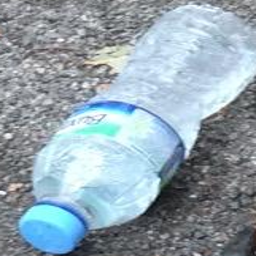

In [26]:
cropped_and_preprocessed_image